## STAT 5010 Project Predictions
## Kirk Van Arkel


## Exploratory Data Analysis

In [51]:
library('tidyverse')
library('MASS')
library('caret')
library('randomForest')
library('sqldf')
library('e1071')
library('leaps')


# read in cleaned up csv file of game data
games <- read.csv('~/Downloads/all_teams_final.csv')
head(games)
names(games)
dim(games)

team,season,name,gameId,opposingTeam,home_or_away,gameDate,situation,corsiPercentage,fenwickPercentage,⋯,giveawaysFor,shotsOnGoalAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,playoffGame
NYR,2008,NYR,2008020001,T.B,AWAY,20081004,other,0.0000,0.0000,⋯,0,1,1,0,0,1,0,1,0,0
NYR,2008,NYR,2008020001,T.B,AWAY,20081004,all,0.6408,0.6310,⋯,8,21,37,1,1,32,17,11,7,0
NYR,2008,NYR,2008020001,T.B,AWAY,20081004,5on5,0.6429,0.6364,⋯,7,11,25,1,1,18,13,9,5,0
NYR,2008,NYR,2008020001,T.B,AWAY,20081004,4on5,0.0909,0.1000,⋯,0,8,10,0,0,2,3,0,1,0
NYR,2008,NYR,2008020001,T.B,AWAY,20081004,5on4,0.9524,0.9444,⋯,1,1,1,0,0,11,1,1,1,0
NYR,2008,NYR,2008020003,T.B,HOME,20081005,other,0.6250,0.6667,⋯,0,1,3,0,0,0,0,0,0,0


[1] "team"                "season"              "name"               
 [4] "gameId"              "opposingTeam"        "home_or_away"       
 [7] "gameDate"            "situation"           "corsiPercentage"    
[10] "fenwickPercentage"   "shotsOnGoalFor"      "shotAttemptsFor"    
[13] "goalsFor"            "reboundsFor"         "penalityMinutesFor" 
[16] "faceOffsWonFor"      "hitsFor"             "takeawaysFor"       
[19] "giveawaysFor"        "shotsOnGoalAgainst"  "shotAttemptsAgainst"
[22] "goalsAgainst"        "reboundsAgainst"     "faceOffsWonAgainst" 
[25] "hitsAgainst"         "takeawaysAgainst"    "giveawaysAgainst"   
[28] "playoffGame"

[1] 139940     28

In [52]:
# include only rows that hold all game information (not separating by special teams)
games <- subset(games, games$situation == "all")
# only include regular season games
games <- subset(games, games$playoffGame == 0)
# remove lockout year
games <- subset(games, games$season != '2012')

# add in binary win column to denote wheter a team won or lost
win = ifelse(games$goalsFor > games$goalsAgainst, 1, 0)
games = games %>%
  mutate(win)
games$win = as.factor(games$win)
head(games)
dim(games)

team,season,name,gameId,opposingTeam,home_or_away,gameDate,situation,corsiPercentage,fenwickPercentage,⋯,shotsOnGoalAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,playoffGame,win
NYR,2008,NYR,2008020001,T.B,AWAY,20081004,all,0.6408,0.6310,⋯,21,37,1,1,32,17,11,7,0,1
NYR,2008,NYR,2008020003,T.B,HOME,20081005,all,0.6207,0.6190,⋯,19,44,1,0,29,31,8,7,0,1
NYR,2008,NYR,2008020010,CHI,HOME,20081010,all,0.4904,0.4643,⋯,32,53,2,2,32,31,8,5,0,1
NYR,2008,NYR,2008020019,PHI,AWAY,20081011,all,0.5000,0.4810,⋯,28,50,3,2,29,11,5,8,0,1
NYR,2008,NYR,2008020034,N.J,HOME,20081013,all,0.4369,0.4507,⋯,27,58,1,4,20,43,9,3,0,1
NYR,2008,NYR,2008020044,BUF,HOME,20081015,all,0.6024,0.5714,⋯,19,33,3,3,23,11,10,1,0,0


[1] 24756    29

In [4]:
#remove columns not needed for analysis
games = games[,-which(names(games) %in% c('name', 'gameDate', 'situation', 'playoffGame'))]
head(games)
summary(games)
#subset(games, team == 'ARI')

team,season,gameId,opposingTeam,home_or_away,corsiPercentage,fenwickPercentage,shotsOnGoalFor,shotAttemptsFor,goalsFor,⋯,giveawaysFor,shotsOnGoalAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,win
NYR,2008,2008020001,T.B,AWAY,0.6408,0.6310,41,66,2,⋯,8,21,37,1,1,32,17,11,7,1
NYR,2008,2008020003,T.B,HOME,0.6207,0.6190,39,72,2,⋯,11,19,44,1,0,29,31,8,7,1
NYR,2008,2008020010,CHI,HOME,0.4904,0.4643,29,51,4,⋯,6,32,53,2,2,32,31,8,5,1
NYR,2008,2008020019,PHI,AWAY,0.5000,0.4810,27,50,4,⋯,3,28,50,3,2,29,11,5,8,1
NYR,2008,2008020034,N.J,HOME,0.4369,0.4507,24,45,4,⋯,10,27,58,1,4,20,43,9,3,1
NYR,2008,2008020044,BUF,HOME,0.6024,0.5714,20,50,1,⋯,6,19,33,3,3,23,11,10,1,0


      team           season         gameId           opposingTeam  
 ANA    :  820   Min.   :2008   Min.   :2.008e+09   ARI    :  901  
 BUF    :  820   1st Qu.:2010   1st Qu.:2.010e+09   BUF    :  819  
 CBJ    :  820   Median :2014   Median :2.014e+09   FLA    :  819  
 CHI    :  820   Mean   :2013   Mean   :2.013e+09   WSH    :  819  
 COL    :  820   3rd Qu.:2016   3rd Qu.:2.016e+09   CAR    :  818  
 DAL    :  820   Max.   :2018   Max.   :2.018e+09   MTL    :  818  
 (Other):19836                                      (Other):19762  
 home_or_away corsiPercentage  fenwickPercentage shotsOnGoalFor 
 AWAY:12460   Min.   :0.2075   Min.   :0.1905    Min.   :10.00  
 HOME:12296   1st Qu.:0.4466   1st Qu.:0.4455    1st Qu.:26.00  
              Median :0.5000   Median :0.5000    Median :30.00  
              Mean   :0.5000   Mean   :0.5000    Mean   :30.41  
              3rd Qu.:0.5534   3rd Qu.:0.5545    3rd Qu.:35.00  
              Max.   :0.7925   Max.   :0.8095    Max.   :61.00  
 

In [5]:
games = subset(games, season %in% c(2010:2018))


In [6]:
# look at correlation matrix of numerical preidctor variables
cor(games[,-c(1,2,3,4,5,25)], method = "pearson")

,corsiPercentage,fenwickPercentage,shotsOnGoalFor,shotAttemptsFor,goalsFor,reboundsFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,shotsOnGoalAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst
corsiPercentage,1.00000000,0.9276227002,0.6240620631,0.787072516,-0.0811647817,0.25510520,-0.11430421,0.162066507,-0.038469147,0.0363071786,0.01834846,-0.6240628663,-0.787073577,0.0811649020,-0.25510569,-0.162066578,0.038468026,-0.0363073634,-0.01834915
fenwickPercentage,0.92762270,1.0000000000,0.6829492722,0.729768675,-0.0002655882,0.29256369,-0.11216471,0.152271146,-0.043380965,0.0538465424,0.01902278,-0.6829487439,-0.729767827,0.0002653578,-0.29256362,-0.152270789,0.043381021,-0.0538456631,-0.01902225
shotsOnGoalFor,0.62406206,0.6829492722,1.0000000000,0.780999812,0.1354479124,0.42448014,-0.05837062,0.255078402,-0.017227348,0.0862814590,0.03849914,-0.1344416024,-0.213271054,0.0605332335,-0.03982438,0.053046465,0.051048900,0.0001611865,0.02365276
shotAttemptsFor,0.78707252,0.7297686749,0.7809998120,1.000000000,-0.0283733635,0.38026483,-0.09015931,0.252635602,0.026137171,0.0983017251,0.12011418,-0.2132710538,-0.257915578,0.1035419619,-0.03328422,-0.007375314,0.086341060,0.0405548334,0.09256776
goalsFor,-0.08116478,-0.0002655882,0.1354479124,-0.028373363,1.0000000000,0.10896040,0.05831277,0.137732409,-0.099964870,0.1098654682,0.01223541,0.0605332335,0.103541962,-0.0553024715,0.02504602,0.089367587,0.043148180,-0.0695368881,0.02681521
reboundsFor,0.25510520,0.2925636916,0.4244801384,0.380264827,0.1089603999,1.00000000,-0.01102976,0.116707270,0.025542273,0.0384799677,0.02658640,-0.0398243768,-0.033284220,0.0250460184,0.06687079,0.018050200,0.033975071,-0.0118501366,0.01075851
penalityMinutesFor,-0.11430421,-0.1121647110,-0.0583706158,-0.090159305,0.0583127697,-0.01102976,1.00000000,0.072556169,0.029837506,-0.0552547404,-0.07299599,0.0983473223,0.090574404,0.0904826944,0.04815582,0.109962242,-0.014893594,-0.0456731784,-0.03225535
faceOffsWonFor,0.16206651,0.1522711457,0.2550784017,0.252635602,0.1377324088,0.11670727,0.07255617,1.000000000,0.003959848,0.0435115370,0.06003643,0.0530464653,-0.007375314,0.0893675866,0.01805020,-0.123270365,0.011899167,-0.0406129733,-0.03310427
hitsFor,-0.03846915,-0.0433809647,-0.0172273480,0.026137171,-0.0999648703,0.02554227,0.02983751,0.003959848,1.000000000,0.0250395930,0.09235943,0.0510488996,0.086341060,0.0431481802,0.03397507,0.011899167,0.392175408,-0.0020682264,0.02776885
takeawaysFor,0.03630718,0.0538465424,0.0862814590,0.098301725,0.1098654682,0.03847997,-0.05525474,0.043511537,0.025039593,1.0000000000,0.25108977,0.0001611865,0.040554833,-0.0695368881,-0.01185014,-0.040612973,-0.002068226,0.3481630899,0.10768420


There looks to be a strong correlation between Corsi and Fenwick percentages, as they are closely related, so for this analysis we will only use Corsi percentage as a predictor.

There's also a lot of correlation between Corsi percentage and  shotAttemptsFor and shotAttemptsAgainst, as the latter two are used in the calculation of Corsi Percentage, so we will disregard these two predictors as well.

In [7]:
# remove Fenwick percentage, shotAttemptsFor, and shotAttemptsAgainst
games = games[,-which(names(games) %in% c('fenwickPercentage', 'shotAttemptsFor', 'shotAttemptsAgainst' ))]
head(games)

,team,season,gameId,opposingTeam,home_or_away,corsiPercentage,shotsOnGoalFor,goalsFor,reboundsFor,penalityMinutesFor,⋯,takeawaysFor,giveawaysFor,shotsOnGoalAgainst,goalsAgainst,reboundsAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,win
165,NYR,2010,2010020013,BUF,AWAY,0.4724,28,6,2,10,⋯,3,5,36,3,2,30,30,5,15,1
166,NYR,2010,2010020028,NYI,AWAY,0.5526,33,4,3,15,⋯,7,9,32,6,3,29,28,15,13,0
167,NYR,2010,2010020049,TOR,HOME,0.4602,24,3,2,21,⋯,7,11,38,4,1,32,29,5,6,0
168,NYR,2010,2010020070,COL,HOME,0.5772,32,1,4,8,⋯,2,4,34,3,5,38,23,1,3,0
169,NYR,2010,2010020083,TOR,AWAY,0.4622,32,2,1,15,⋯,6,5,25,1,1,31,21,9,11,1
170,NYR,2010,2010020098,BOS,AWAY,0.4841,30,3,1,27,⋯,11,5,37,2,0,28,33,2,10,1


In [8]:
dim(games)
cor(games[, - c(1,2,3,4,5,22)], method = 'pearson')


[1] 19844    22

,corsiPercentage,shotsOnGoalFor,goalsFor,reboundsFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,shotsOnGoalAgainst,goalsAgainst,reboundsAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst
corsiPercentage,1.00000000,0.6240620631,-0.08116478,0.25510520,-0.11430421,0.162066507,-0.038469147,0.0363071786,0.01834846,-0.6240628663,0.08116490,-0.25510569,-0.162066578,0.038468026,-0.0363073634,-0.01834915
shotsOnGoalFor,0.62406206,1.0000000000,0.13544791,0.42448014,-0.05837062,0.255078402,-0.017227348,0.0862814590,0.03849914,-0.1344416024,0.06053323,-0.03982438,0.053046465,0.051048900,0.0001611865,0.02365276
goalsFor,-0.08116478,0.1354479124,1.00000000,0.10896040,0.05831277,0.137732409,-0.099964870,0.1098654682,0.01223541,0.0605332335,-0.05530247,0.02504602,0.089367587,0.043148180,-0.0695368881,0.02681521
reboundsFor,0.25510520,0.4244801384,0.10896040,1.00000000,-0.01102976,0.116707270,0.025542273,0.0384799677,0.02658640,-0.0398243768,0.02504602,0.06687079,0.018050200,0.033975071,-0.0118501366,0.01075851
penalityMinutesFor,-0.11430421,-0.0583706158,0.05831277,-0.01102976,1.00000000,0.072556169,0.029837506,-0.0552547404,-0.07299599,0.0983473223,0.09048269,0.04815582,0.109962242,-0.014893594,-0.0456731784,-0.03225535
faceOffsWonFor,0.16206651,0.2550784017,0.13773241,0.11670727,0.07255617,1.000000000,0.003959848,0.0435115370,0.06003643,0.0530464653,0.08936759,0.01805020,-0.123270365,0.011899167,-0.0406129733,-0.03310427
hitsFor,-0.03846915,-0.0172273480,-0.09996487,0.02554227,0.02983751,0.003959848,1.000000000,0.0250395930,0.09235943,0.0510488996,0.04314818,0.03397507,0.011899167,0.392175408,-0.0020682264,0.02776885
takeawaysFor,0.03630718,0.0862814590,0.10986547,0.03847997,-0.05525474,0.043511537,0.025039593,1.0000000000,0.25108977,0.0001611865,-0.06953689,-0.01185014,-0.040612973,-0.002068226,0.3481630899,0.10768420
giveawaysFor,0.01834846,0.0384991364,0.01223541,0.02658640,-0.07299599,0.060036427,0.092359433,0.2510897672,1.00000000,0.0236527605,0.02681521,0.01075851,-0.033104271,0.027768852,0.1076841981,0.42549345
shotsOnGoalAgainst,-0.62406287,-0.1344416024,0.06053323,-0.03982438,0.09834732,0.053046465,0.051048900,0.0001611865,0.02365276,1.0000000000,0.13544791,0.42448014,0.255078402,-0.017227348,0.0862814590,0.03849914


We are now down to 20 columns total, and look to have elimnated the heavy correlations between potential predictors.  The team and season columns will not be used as predictors (nor will goals for as goals for and goals against together would give win), but the remaining columns will be used to predict the final one, win.

### Predicting Win based off that games stats

In [9]:
# split model into training and testing

train = subset(games, games$season %in% c(2010:2017))
test = subset(games, games$season == 2018)

# run a logistic regression
logmod = glm(win ~ . - team - season - gameId - opposingTeam - goalsAgainst, family = binomial(link = 'logit'), data = train)
summary(logmod)


Call:
glm(formula = win ~ . - team - season - gameId - opposingTeam - 
    goalsAgainst, family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.2985  -0.5809  -0.1860   0.5296   3.2014  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          8.445624   0.346642  24.364  < 2e-16 ***
home_or_awayHOME     0.438638   0.057957   7.568 3.78e-14 ***
corsiPercentage    -13.245891   0.536489 -24.690  < 2e-16 ***
shotsOnGoalFor       0.026519   0.005026   5.276 1.32e-07 ***
goalsFor             1.393494   0.022308  62.467  < 2e-16 ***
reboundsFor          0.032503   0.014449   2.249   0.0245 *  
penalityMinutesFor  -0.024662   0.004190  -5.886 3.95e-09 ***
faceOffsWonFor      -0.043525   0.004126 -10.548  < 2e-16 ***
hitsFor             -0.028615   0.003052  -9.377  < 2e-16 ***
takeawaysFor         0.056328   0.006665   8.452  < 2e-16 ***
giveawaysFor        -0.044170   0.005784  -7.637 2

In [10]:
# use logistic regression model to predict wins with testing data
preds = predict(logmod, test, type = "response")
preds = ifelse(preds>0.5,1,0)
preds = as.factor(preds)
test$win = as.factor(test$win)
confusionMatrix(preds, test$win)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1131  206
         1  227  978
                                          
               Accuracy : 0.8297          
                 95% CI : (0.8145, 0.8441)
    No Information Rate : 0.5342          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6581          
                                          
 Mcnemar's Test P-Value : 0.3365          
                                          
            Sensitivity : 0.8328          
            Specificity : 0.8260          
         Pos Pred Value : 0.8459          
         Neg Pred Value : 0.8116          
             Prevalence : 0.5342          
         Detection Rate : 0.4449          
   Detection Prevalence : 0.5260          
      Balanced Accuracy : 0.8294          
                                          
       'Positive' Class : 0               
                        

From our first logistic regression model, a team's stats in a game allowed us to correctly predict whether that team won or lost with $82.85\%$ accuracy.  This is much better than guessing at $50\%$ and is pretty good considering the unpredictable nature of hockey. The concrete hockey stats often do not tell the whole story of a game.


### Clean data and arrange it to predict single game outcome

In [11]:
clean = sqldf("select team, season, home_or_away, count(team)
            from games
            group by team, season, home_or_away
            having count(team) != 41 and count(team) != 24")
clean

team,season,home_or_away,count(team)
ARI,2011,AWAY,82
ARI,2013,AWAY,82


In [12]:
clean = sqldf("select * from games
        where team != 'ARI' and opposingTeam != 'ARI'")
summary(clean)

      team           season         gameId           opposingTeam  
 BUF    :  642   Min.   :2010   Min.   :2.010e+09   BUF    :  642  
 CAR    :  642   1st Qu.:2013   1st Qu.:2.013e+09   CAR    :  642  
 FLA    :  642   Median :2015   Median :2.015e+09   FLA    :  642  
 MTL    :  642   Mean   :2014   Mean   :2.014e+09   MTL    :  642  
 N.J    :  642   3rd Qu.:2017   3rd Qu.:2.017e+09   N.J    :  642  
 NYI    :  642   Max.   :2018   Max.   :2.018e+09   NYI    :  642  
 (Other):14680                                      (Other):14680  
 home_or_away corsiPercentage  shotsOnGoalFor     goalsFor     
 AWAY:9266    Min.   :0.2075   Min.   :10.00   Min.   : 0.000  
 HOME:9266    1st Qu.:0.4468   1st Qu.:26.00   1st Qu.: 2.000  
              Median :0.5000   Median :30.00   Median : 3.000  
              Mean   :0.5000   Mean   :30.42   Mean   : 2.761  
              3rd Qu.:0.5532   3rd Qu.:35.00   3rd Qu.: 4.000  
              Max.   :0.7925   Max.   :60.00   Max.   :10.000  
        

In [13]:
home = sqldf("SELECT * from clean 
         where home_or_away = 'HOME' ")

away = sqldf("SELECT * from clean
         where home_or_away = 'AWAY' ")
dim(home)
dim(away)
dim(clean)

[1] 9266   22

[1] 9266   22

[1] 18532    22

^^^ Make data frame per team then for year then for averages.

In [262]:
teams = c('ANA', 'ATL', 'BOS', 'BUF', 'CAR', 'CBJ', 'CGY', 'CHI', 'COL', 'DAL', 'DET', 'EDM', 
          'FLA', 'L.A', 'MIN', 'MTL', 'NSH', 'N.J', 'NYI', 'NYR', 'OTT', 'PHI', 'PIT', 'S.J',
          'STL', 'T.B', 'TOR', 'VAN', 'VGK', 'WPG', 'WSH')
years = c('2010', '2011', '2013', '2014', '2015', '2016', '2017', '2018')
t_total = data.frame()

n=15

for (t in teams){
    team.df = subset(games, team == t)
    for (y in years){
        team.year.df = subset(team.df, season == y)
        for (g in (n+1):82){
            team.year.df[g, 'avg_Corsi'] = mean(team.year.df['corsiPercentage'][(g-n):(g-1),1])
            team.year.df[g, 'avg_SOG_For'] = mean(team.year.df['shotsOnGoalFor'][(g-n):(g-1),1])
            team.year.df[g, 'avg_goals_For'] = mean(team.year.df['goalsFor'][(g-n):(g-1),1])
            team.year.df[g, 'avg_goals_Against'] = mean(team.year.df['goalsAgainst'][(g-n):(g-1),1])
            team.year.df[g, 'avg_rebounds_For'] = mean(team.year.df['reboundsFor'][(g-n):(g-1),1])
            team.year.df[g, 'avg_PIM_For'] = mean(team.year.df['penalityMinutesFor'][(g-n):(g-1),1])
            team.year.df[g, 'avg_FO_Win_For'] = mean(team.year.df['faceOffsWonFor'][(g-n):(g-1),1])
            team.year.df[g, 'avg_hits_For'] = mean(team.year.df['hitsFor'][(g-n):(g-1),1])
            team.year.df[g, 'avg_takeaways_For'] = mean(team.year.df['takeawaysFor'][(g-n):(g-1),1])
            team.year.df[g, 'avg_giveaways_For'] = mean(team.year.df['giveawaysFor'][(g-n):(g-1),1])
            team.year.df[g, 'num_wins'] = sum(as.numeric(as.character(team.year.df['win'][(g-n):(g-1),1])))
            df = drop_na(team.year.df)
        }
        t_total = rbind(t_total, df)
    }
}
dim(t_total)
dim(subset(t_total, team == 'NYR' ))#& season == '2010' ))
#subset(clean, team == 'COL' & season == '2012')
#t_total

[1] 15678    40

[1] 536  40

In [263]:
dim(sqldf('select distinct gameId from t_total'))

[1] 8169    1

In [264]:
head(t_total)

,team,season,name,gameId,opposingTeam,home_or_away,gameDate,situation,corsiPercentage,fenwickPercentage,⋯,avg_SOG_For,avg_goals_For,avg_goals_Against,avg_rebounds_For,avg_PIM_For,avg_FO_Win_For,avg_hits_For,avg_takeaways_For,avg_giveaways_For,num_wins
8133,ANA,2010,ANA,2010020210,S.J,AWAY,20101109,all,0.3333,0.3444,⋯,28.20000,2.666667,3.266667,1.466667,16.33333,28.26667,22.66667,4.800000,6.266667,7
8134,ANA,2010,ANA,2010020216,NYI,HOME,20101110,all,0.3505,0.3043,⋯,28.13333,2.866667,3.133333,1.466667,15.60000,28.66667,22.20000,4.466667,6.266667,8
8135,ANA,2010,ANA,2010020232,DAL,HOME,20101112,all,0.5347,0.5595,⋯,26.60000,2.866667,2.866667,1.400000,15.46667,28.20000,22.93333,4.400000,6.533333,9
8136,ANA,2010,ANA,2010020247,CHI,AWAY,20101114,all,0.3684,0.3592,⋯,28.13333,3.066667,2.666667,1.400000,11.86667,29.00000,23.46667,4.533333,6.733333,10
8137,ANA,2010,ANA,2010020256,DAL,AWAY,20101116,all,0.4762,0.4872,⋯,27.73333,2.933333,2.666667,1.266667,11.53333,29.13333,23.66667,4.533333,6.266667,9
8138,ANA,2010,ANA,2010020264,MIN,AWAY,20101117,all,0.4904,0.4881,⋯,26.80000,2.733333,2.533333,1.333333,12.13333,28.73333,23.60000,4.133333,6.200000,9


In [265]:
home = sqldf("select * from t_total where home_or_away = 'HOME' ")
away = sqldf("select * from t_total where home_or_away = 'AWAY' ")

allgame = sqldf("select h.gameId, h.season, h.team as home_team,
        h.num_wins as home_NumWins, h.avg_Corsi as home_avgCorsi,
        h.avg_SOG_For as home_avgSOG, h.avg_rebounds_For as home_avgrebounds_for,
        h.avg_goals_For as home_avgGF, h.avg_goals_Against as home_avgGA,
        h.avg_PIM_For as home_avgPIM, h.avg_FO_Win_For as home_avgFO_win,
        h.avg_hits_For as home_avgHits_For, h.avg_takeaways_For as home_avgTA_For,
        h.avg_giveaways_For as home_avgGiveaways_For,
        a.team as away_team, a.num_wins as away_NumWins,
        a.avg_Corsi as away_avgCorsi,
        a.avg_SOG_For as away_avgSOG, a.avg_rebounds_For as away_avgrebounds_for,
        a.avg_PIM_For as away_avgPIM, a.avg_goals_For as away_avgGF,
        a.avg_goals_Against as away_avgGA, a.avg_FO_Win_For as away_avgFO_win,
        a.avg_hits_For as away_avgHits_For, a.avg_takeaways_For as away_avgTA_For,
        a.avg_giveaways_For as away_avgGiveaways_For, h.win as home_win from home h
        inner join away a on a.gameId = h.gameId")

head(allgame)
dim(allgame)

gameId,season,home_team,home_NumWins,home_avgCorsi,home_avgSOG,home_avgrebounds_for,home_avgGF,home_avgGA,home_avgPIM,⋯,away_avgSOG,away_avgrebounds_for,away_avgPIM,away_avgGF,away_avgGA,away_avgFO_win,away_avgHits_For,away_avgTA_For,away_avgGiveaways_For,home_win
2010020282,2010,ANA,8,0.4454533,26.33333,1.333333,2.600000,2.533333,12.20000,⋯,30.60000,1.800000,10.800000,2.866667,2.533333,31.80000,24.33333,7.666667,3.666667,0
2010020296,2010,ANA,8,0.4413200,27.53333,1.533333,2.733333,2.600000,12.53333,⋯,26.06667,1.666667,15.333333,2.400000,4.400000,26.86667,21.33333,7.400000,10.866667,0
2010020326,2010,ANA,7,0.4557333,28.73333,1.600000,2.666667,2.733333,11.93333,⋯,35.40000,1.933333,8.600000,3.000000,3.066667,28.46667,20.20000,11.333333,7.866667,0
2010020352,2010,ANA,7,0.4552667,28.80000,1.800000,2.533333,2.800000,12.06667,⋯,29.66667,2.200000,13.466667,2.600000,2.533333,29.20000,25.00000,6.066667,10.666667,1
2010020364,2010,ANA,8,0.4482133,28.20000,1.666667,2.600000,2.666667,12.26667,⋯,34.13333,2.733333,8.666667,2.533333,2.800000,31.13333,17.33333,7.066667,5.333333,1
2010020378,2010,ANA,9,0.4497600,28.53333,1.600000,2.800000,2.533333,10.06667,⋯,34.13333,2.000000,9.933333,3.666667,2.733333,30.40000,21.20000,7.333333,9.133333,0


[1] 7509   27

In [266]:
allgames = sqldf('select gameId, season, home_team, away_team,
                home_NumWins-away_NumWins as HA_NumWins_diff,
                home_avgCorsi-away_avgCorsi as HA_avgCorsi_diff,
                home_avgGF-away_avgGF as HA_avgGF_diff,
                home_avgGA-away_avgGA as HA_avgGA_diff,
                home_avgSOG-away_avgSOG as HA_avgSOG_diff, 
                home_avgrebounds_for- away_avgrebounds_for as HA_avgReboundsFor_diff,
                home_avgPIM-away_avgPIM as HA_avgPIM_diff,
                home_avgFO_win-away_avgFO_win as HA_avg_FOwin_diff,
                home_avgHits_For-away_avgHits_For as HA_avgHits_diff,
                home_avgTA_For-away_avgTA_For as HA_avgTA_diff,
                home_avgGiveaways_For-away_avgGiveaways_For as HA_avgGiveaways_diff,
                home_win
                from allgame')

head(allgames)
dim(allgames)
allgames$home_win = as.factor(allgames$home_win)


#standardize 
allgames[,6:15] = scale(allgames[,6:15])

gameId,season,home_team,away_team,HA_NumWins_diff,HA_avgCorsi_diff,HA_avgGF_diff,HA_avgGA_diff,HA_avgSOG_diff,HA_avgReboundsFor_diff,HA_avgPIM_diff,HA_avg_FOwin_diff,HA_avgHits_diff,HA_avgTA_diff,HA_avgGiveaways_diff,home_win
2010020282,2010,ANA,CBJ,-1,-0.05031333,-0.26666667,0.0000000,-4.2666667,-0.4666667,1.4000000,-3.3333333,-0.8666667,-3.533333,2.6000000,0
2010020296,2010,ANA,EDM,6,0.00240000,0.33333333,-1.8000000,1.4666667,-0.1333333,-2.8000000,1.6000000,2.6666667,-3.066667,-4.3333333,0
2010020326,2010,ANA,CHI,2,-0.09848667,-0.33333333,-0.3333333,-6.6666667,-0.3333333,3.3333333,-0.4666667,4.2000000,-7.000000,-1.6666667,0
2010020352,2010,ANA,L.A,1,-0.03707333,-0.06666667,0.2666667,-0.8666667,-0.4000000,-1.4000000,-0.8666667,-1.8000000,-2.066667,-4.8666667,1
2010020364,2010,ANA,FLA,2,-0.05848000,0.06666667,-0.1333333,-5.9333333,-1.0666667,3.6000000,-2.9333333,6.0000000,-3.266667,0.5333333,1
2010020378,2010,ANA,DET,-2,-0.09286000,-0.86666667,-0.2000000,-5.6000000,-0.4000000,0.1333333,-3.3333333,1.8666667,-3.466667,-3.1333333,0


[1] 7509   16

In [272]:
set.seed(11)
shuff = allgames[sample(length(allgames[,1])),]
trainSize = floor(0.8*length(allgames[,1])) 
n = trainSize
n
trains = shuff[1:trainSize,]
tests = shuff[trainSize:length(allgames[,1]),]
dim(tests)
#trains = subset(allgames, season %in% c(2010:2017))
#tests = subset(allgames, season == 2018)
#head(trains)

gmod = glm(home_win ~ . -gameId -home_team -away_team -season, family = binomial(link = 'logit'),
          data = trains)
summary(gmod)

[1] 6007

[1] 1503   16


Call:
glm(formula = home_win ~ . - gameId - home_team - away_team - 
    season, family = binomial(link = "logit"), data = trains)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.626  -1.139  -0.865   1.172   1.726  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -0.054388   0.026173  -2.078  0.03771 *  
HA_NumWins_diff         0.008875   0.017260   0.514  0.60712    
HA_avgCorsi_diff        0.170657   0.038454   4.438 9.08e-06 ***
HA_avgGF_diff           0.139299   0.044439   3.135  0.00172 ** 
HA_avgGA_diff          -0.129943   0.040078  -3.242  0.00119 ** 
HA_avgSOG_diff          0.067722   0.043627   1.552  0.12059    
HA_avgReboundsFor_diff -0.049575   0.030032  -1.651  0.09879 .  
HA_avgPIM_diff          0.013319   0.028828   0.462  0.64408    
HA_avg_FOwin_diff      -0.024109   0.028495  -0.846  0.39751    
HA_avgHits_diff         0.031939   0.028269   1.130  0.25856    
HA_avgTA_diff          -0.038865  

In [273]:
preds = predict(gmod, tests, type = 'response')
predis = as.factor(ifelse(preds>0.5, 1, 0))
confusionMatrix(predis, tests$home_win)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 471 371
         1 283 378
                                          
               Accuracy : 0.5649          
                 95% CI : (0.5394, 0.5901)
    No Information Rate : 0.5017          
    P-Value [Acc > NIR] : 5.252e-07       
                                          
                  Kappa : 0.1294          
                                          
 Mcnemar's Test P-Value : 0.000669        
                                          
            Sensitivity : 0.6247          
            Specificity : 0.5047          
         Pos Pred Value : 0.5594          
         Neg Pred Value : 0.5719          
             Prevalence : 0.5017          
         Detection Rate : 0.3134          
   Detection Prevalence : 0.5602          
      Balanced Accuracy : 0.5647          
                                          
       'Positive' Class : 0               
                              

In [274]:
rs = regsubsets(home_win ~ . -gameId -home_team -away_team -season, data = trains)
summary(rs)
summary(rs)$bic

Subset selection object
Call: regsubsets.formula(home_win ~ . - gameId - home_team - away_team - 
    season, data = trains)
11 Variables  (and intercept)
                       Forced in Forced out
HA_NumWins_diff            FALSE      FALSE
HA_avgCorsi_diff           FALSE      FALSE
HA_avgGF_diff              FALSE      FALSE
HA_avgGA_diff              FALSE      FALSE
HA_avgSOG_diff             FALSE      FALSE
HA_avgReboundsFor_diff     FALSE      FALSE
HA_avgPIM_diff             FALSE      FALSE
HA_avg_FOwin_diff          FALSE      FALSE
HA_avgHits_diff            FALSE      FALSE
HA_avgTA_diff              FALSE      FALSE
HA_avgGiveaways_diff       FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: exhaustive
         HA_NumWins_diff HA_avgCorsi_diff HA_avgGF_diff HA_avgGA_diff
1  ( 1 ) " "             "*"              " "           " "          
2  ( 1 ) "*"             "*"              " "           " "          
3  ( 1 ) " "             "*"              "*

[1]  -62.37378 -110.57101 -117.22957 -111.68558 -104.41390  -97.57265  -90.59073
[8]  -82.52346

In [275]:
gm2 = glm(home_win ~ HA_avgCorsi_diff + HA_avgGF_diff + HA_avgGA_diff,
          data = trains, family = binomial)
summary(gm2)


Call:
glm(formula = home_win ~ HA_avgCorsi_diff + HA_avgGF_diff + HA_avgGA_diff, 
    family = binomial, data = trains)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6563  -1.1396  -0.8785   1.1722   1.7682  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.05447    0.02615  -2.083   0.0372 *  
HA_avgCorsi_diff  0.18709    0.02679   6.983 2.89e-12 ***
HA_avgGF_diff     0.15643    0.02687   5.822 5.81e-09 ***
HA_avgGA_diff    -0.14612    0.02681  -5.450 5.04e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 8323.5  on 6006  degrees of freedom
Residual deviance: 8171.3  on 6003  degrees of freedom
AIC: 8179.3

Number of Fisher Scoring iterations: 4


$$logit(P(Win)) = -0.054 + 0.19X_{Corsi.d} + 0.16X_{GF.d} - 0.15X_{GA.d} $$

In [276]:
preds2 = predict(gm2, tests, type='response')
predis2 = as.factor(ifelse(preds2>0.5,1,0))
confusionMatrix(predis2, tests$home_win)
length(preds2)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 481 363
         1 273 386
                                         
               Accuracy : 0.5768         
                 95% CI : (0.5514, 0.602)
    No Information Rate : 0.5017         
    P-Value [Acc > NIR] : 3.027e-09      
                                         
                  Kappa : 0.1533         
                                         
 Mcnemar's Test P-Value : 0.000417       
                                         
            Sensitivity : 0.6379         
            Specificity : 0.5154         
         Pos Pred Value : 0.5699         
         Neg Pred Value : 0.5857         
             Prevalence : 0.5017         
         Detection Rate : 0.3200         
   Detection Prevalence : 0.5615         
      Balanced Accuracy : 0.5766         
                                         
       'Positive' Class : 0              
                                         

[1] 1503

In [288]:
rf = randomForest(home_win ~ . -gameId -home_team -away_team -season, 
                  data = trains, ntree =250, importance = T)

In [289]:
rf


Call:
 randomForest(formula = home_win ~ . - gameId - home_team - away_team -      season, data = trains, ntree = 250, importance = T) 
               Type of random forest: classification
                     Number of trees: 250
No. of variables tried at each split: 3

        OOB estimate of  error rate: 46.43%
Confusion matrix:
     0    1 class.error
0 1734 1347   0.4371957
1 1442 1484   0.4928230

In [290]:
predsrf = predict(rf, tests, type = 'response')
confusionMatrix(predsrf, tests$home_win)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 447 384
         1 307 365
                                          
               Accuracy : 0.5403          
                 95% CI : (0.5147, 0.5657)
    No Information Rate : 0.5017          
    P-Value [Acc > NIR] : 0.001499        
                                          
                  Kappa : 0.0802          
                                          
 Mcnemar's Test P-Value : 0.003838        
                                          
            Sensitivity : 0.5928          
            Specificity : 0.4873          
         Pos Pred Value : 0.5379          
         Neg Pred Value : 0.5432          
             Prevalence : 0.5017          
         Detection Rate : 0.2974          
   Detection Prevalence : 0.5529          
      Balanced Accuracy : 0.5401          
                                          
       'Positive' Class : 0               
                              

In [281]:
svmfit = svm(home_win ~ . -gameId -home_team -away_team -season, data = trains, kernel = 'linear', cost = 1, scale = F)

In [282]:
svmfit


Call:
svm(formula = home_win ~ . - gameId - home_team - away_team - season, 
    data = trains, kernel = "linear", cost = 1, scale = F)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 
      gamma:  0.09090909 

Number of Support Vectors:  5519


In [283]:
preds = as.factor(predict(svmfit, tests, type = 'response'))
length(preds)

[1] 1503

In [284]:
confusionMatrix(preds, tests$home_win)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 477 375
         1 277 374
                                          
               Accuracy : 0.5662          
                 95% CI : (0.5407, 0.5914)
    No Information Rate : 0.5017          
    P-Value [Acc > NIR] : 3.089e-07       
                                          
                  Kappa : 0.132           
                                          
 Mcnemar's Test P-Value : 0.0001454       
                                          
            Sensitivity : 0.6326          
            Specificity : 0.4993          
         Pos Pred Value : 0.5599          
         Neg Pred Value : 0.5745          
             Prevalence : 0.5017          
         Detection Rate : 0.3174          
   Detection Prevalence : 0.5669          
      Balanced Accuracy : 0.5660          
                                          
       'Positive' Class : 0               
                              

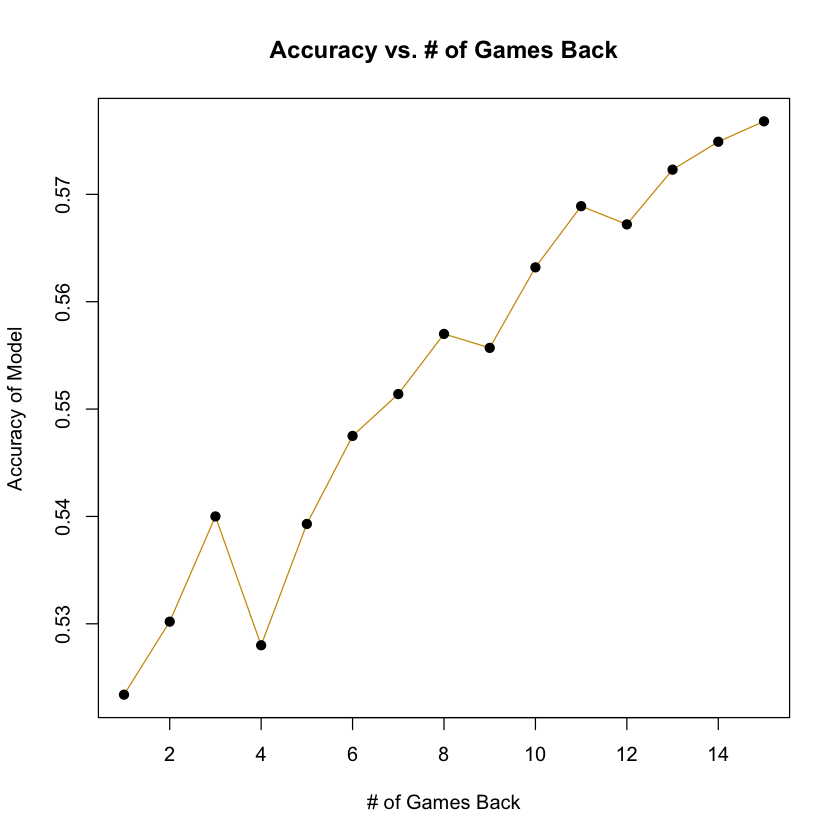

In [291]:
acc = c(0.5234,0.5302,0.54,0.528,0.5393,0.5475,0.5514, 0.5570, 0.5557, 0.5632, 0.5689, .5672, 0.5723, 0.5749, 0.5768 )

plot(c(1:15),acc, type ='l', col='#CC9900', xlab = '# of Games Back', ylab = 'Accuracy of Model', 
    main = 'Accuracy vs. # of Games Back')
points(c(1:15), acc, pch = 19)

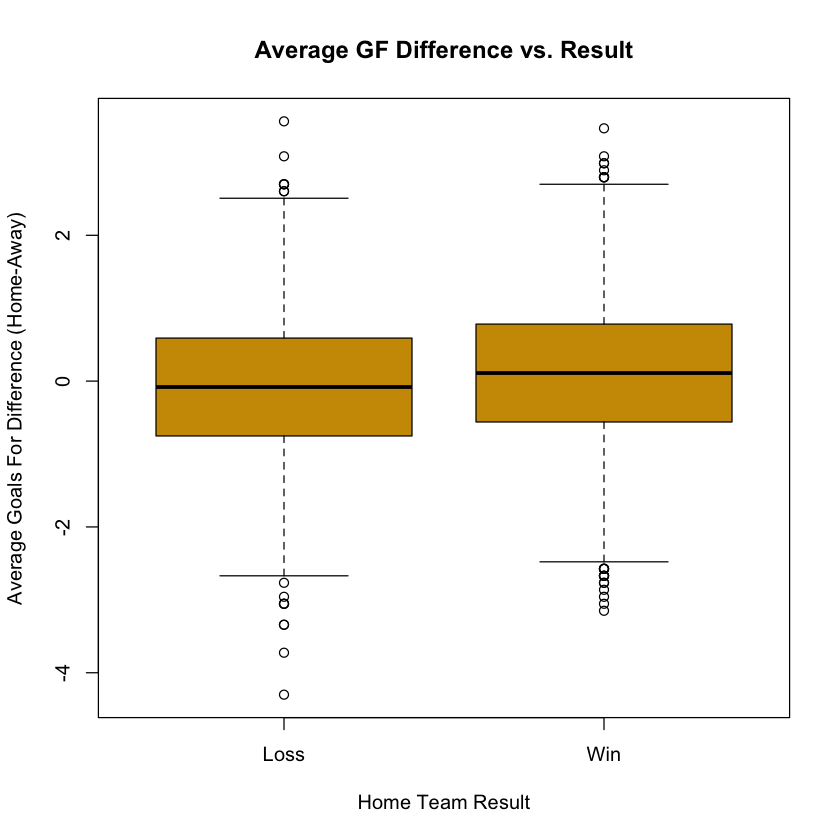

In [308]:
levels(trains$home_win) = c('Loss', 'Win')
#par(mfrow = c(3,1))
#with(trains, boxplot(HA_avgCorsi_diff ~ home_win, xlab = 'Home Team Result', 
#                     ylab = 'Average Corsi Difference (Home-Away)',
#                    main = 'Average Corsi Difference vs. Result', col = '#CC9900'))
#with(trains, boxplot(HA_avgGA_diff ~ home_win, xlab = 'Home Team Result', 
#                     ylab = 'Average Goals Against Difference (Home-Away)',
#                    main = 'Average GA Difference vs. Result', col = '#CC9900'))
with(trains, boxplot(HA_avgGF_diff ~ home_win, xlab = 'Home Team Result', 
                     ylab = 'Average Goals For Difference (Home-Away)',
                    main = 'Average GF Difference vs. Result', col = '#CC9900'))

In [317]:
levels(tests$home_win) = c('Loss', 'Win')
levels(predis) = c('Loss', 'Win')
dd = data.frame('Home.Team' = tests$home_team,
          'Away.Team' = tests$away_team,
          'Corsi.Diff' = tests$HA_avgCorsi_diff,
          'Goals.Against.Diff' = tests$HA_avgGA_diff,
          'Goals.For.Diff' = tests$HA_avgGF_diff,
          'Home.Result'= tests$home_win,
          'Home.Pred.Results' = predis)
dd[10:15,]

,Home.Team,Away.Team,Corsi.Diff,Goals.Against.Diff,Goals.For.Diff,Home.Result,Home.Pred.Results
2916,FLA,WPG,-0.5883315,-2.07414558,-1.7113548,Loss,Loss
7177,WPG,COL,-0.1365746,0.67303700,2.1245197,Win,Win
5808,S.J,DET,0.3855535,0.47680967,-0.1770050,Loss,Loss
4828,NYR,CHI,-0.5433762,0.08435502,1.3573448,Loss,Win
363,BOS,CBJ,0.6358929,-1.48546360,0.3983762,Win,Win
3611,MIN,BOS,-0.8610017,-0.70055429,-2.6703235,Loss,Loss
